# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test1'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

datasets_paths = {}
for lang in os.listdir(datasets_path):
    dataset_lang_path = os.path.join(datasets_path, lang)
    if os.path.isdir(dataset_lang_path):
        datasets_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            datasets_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'sentence_len': 126, # maximum length from french dataset
}

# Word Embedding

A first initial test will be to start with the model used in the Homework #1, and so we need to generate the word embedding from GloVe

In [6]:
embedding_word_freeze = True

In [7]:
from stud.modelsTests.utils.gensim_embedding_generator import generate_embedding_and_vocab, save_embedding_layer

embedding_layer, vocabulary = generate_embedding_and_vocab(
                                gensim_name = 'glove-wiki-gigaword-300', 
                                freeze = embedding_word_freeze, 
                                pad_token = global_params['PAD_TOKEN'], 
                                unk_token = global_params['UNK_TOKEN'])

In [8]:
embedding_layer.num_embeddings, embedding_layer.embedding_dim

(400002, 300)

In [9]:
vocabulary['index_to_key'][-2], vocabulary['index_to_key'][-1]

('<pad>', '<unk>')

In [10]:
vocabulary['key_to_index'][global_params['PAD_TOKEN']], vocabulary['key_to_index'][global_params['UNK_TOKEN']]

(400000, 400001)

In [11]:
vocabulary['pad_token'], vocabulary['pad_id'], vocabulary['unk_token'], vocabulary['unk_id']

('<pad>', 400000, '<unk>', 400001)

In [12]:
save_embedding_layer(embedding_layer, os.path.join(model_dir_path, 'word_embedding.pth'))

# Dataset Analysis

In [13]:
from stud.modelsTests.dataset.SRLDataset_word_embedding import SRLDataset_word_embedding

In [14]:
import matplotlib.pyplot as plt

def print_counter_distribution(counter):
    plt.figure(figsize=(22, 6))
    plt.xticks(rotation=15)
    plt.bar(counter.keys(),counter.values(), width=0.4)
    plt.show()

For now, we will use only english as starting point with vocabulary, but knowing that the maximum length of a sentence is 126 (french dataset):

In [15]:
dataset_train_en = SRLDataset_word_embedding(   datasets_paths['EN']['train'], 
                                                word_vocabulary = vocabulary, 
                                                baselines_file_path = os.path.join(app_root,'data/baselines.json'),
                                                max_length_sentence = global_params['sentence_len'])
dataset_train_es = SRLDataset_word_embedding(   datasets_paths['ES']['train'], 
                                                word_vocabulary = vocabulary, 
                                                labels = dataset_train_en.labels,
                                                max_length_sentence = global_params['sentence_len'])
dataset_train_fr = SRLDataset_word_embedding(   datasets_paths['FR']['train'], 
                                                word_vocabulary = vocabulary, 
                                                labels = dataset_train_en.labels,
                                                max_length_sentence = global_params['sentence_len'])

In [16]:
SRLDataset_word_embedding.save_dict(
    os.path.join(model_dir_path, 'EN_word_vocabulary.npy'), 
    dataset_train_en.word_vocabulary)
SRLDataset_word_embedding.save_dict(
    os.path.join(model_dir_path, 'labels.npy'), 
    dataset_train_en.labels)

In [17]:
words_in_train = list(set(word for sample in dataset_train_en for word in sample['words']))
lemmas_in_train = list(set(word for sample in dataset_train_en for word in sample['lemmas']))
words_not_present = len([w for w in words_in_train if w not in vocabulary['key_to_index']])
lemmas_not_present = len([w for w in lemmas_in_train if w not in vocabulary['key_to_index']])
words_in_train = len(words_in_train)
lemmas_in_train = len(lemmas_in_train)
print('EN')
print(words_not_present, 'words not present out of', words_in_train, ' so:', f'{(100*words_not_present/words_in_train):0.2f}', '%')
print(lemmas_not_present, 'lemmas not present out of', lemmas_in_train, ' so:', f'{(100*lemmas_not_present/lemmas_in_train):0.2f}', '%')

EN
2874 words not present out of 8787  so: 32.71 %
2222 lemmas not present out of 6761  so: 32.86 %


In [18]:
words_in_train = list(set(word for sample in dataset_train_es for word in sample['words']))
lemmas_in_train = list(set(word for sample in dataset_train_es for word in sample['lemmas']))
words_not_present = len([w for w in words_in_train if w not in vocabulary['key_to_index']])
lemmas_not_present = len([w for w in lemmas_in_train if w not in vocabulary['key_to_index']])
words_in_train = len(words_in_train)
lemmas_in_train = len(lemmas_in_train)
print('ES')
print(words_not_present, 'words not present out of', words_in_train, ' so:', f'{(100*words_not_present/words_in_train):0.2f}', '%')
print(lemmas_not_present, 'lemmas not present out of', lemmas_in_train, ' so:', f'{(100*lemmas_not_present/lemmas_in_train):0.2f}', '%')

ES
2081 words not present out of 3173  so: 65.58 %
1499 lemmas not present out of 2401  so: 62.43 %


In [19]:
words_in_train = list(set(word for sample in dataset_train_fr for word in sample['words']))
lemmas_in_train = list(set(word for sample in dataset_train_fr for word in sample['lemmas']))
words_not_present = len([w for w in words_in_train if w not in vocabulary['key_to_index']])
lemmas_not_present = len([w for w in lemmas_in_train if w not in vocabulary['key_to_index']])
words_in_train = len(words_in_train)
lemmas_in_train = len(lemmas_in_train)
print('FR')
print(words_not_present, 'words not present out of', words_in_train, ' so:', f'{(100*words_not_present/words_in_train):0.2f}', '%')
print(lemmas_not_present, 'lemmas not present out of', lemmas_in_train, ' so:', f'{(100*lemmas_not_present/lemmas_in_train):0.2f}', '%')

FR
1894 words not present out of 3000  so: 63.13 %
1246 lemmas not present out of 2202  so: 56.58 %


In [20]:
dataset_dev_en = SRLDataset_word_embedding( datasets_paths['EN']['dev'], 
                                            word_vocabulary = vocabulary, 
                                            labels = dataset_train_en.labels,
                                            max_length_sentence = global_params['sentence_len'])

EN roles labels 26


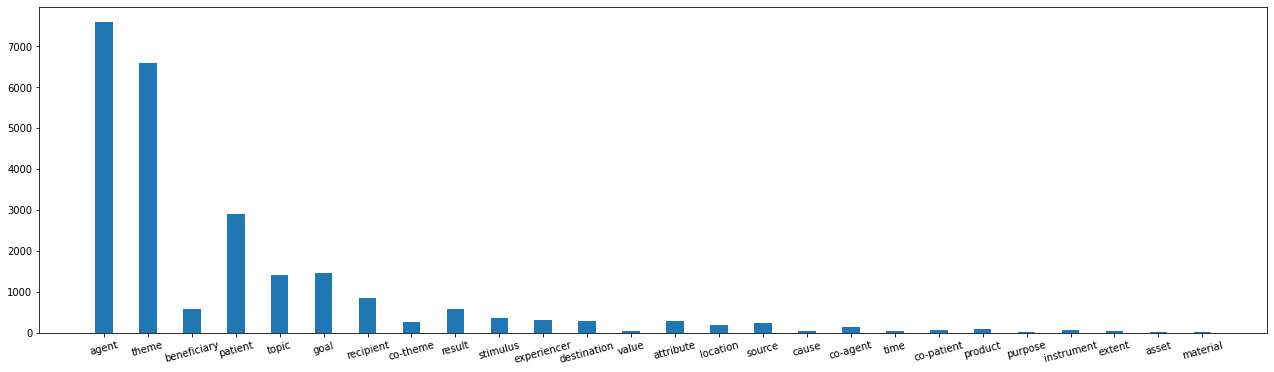

ES roles labels 25


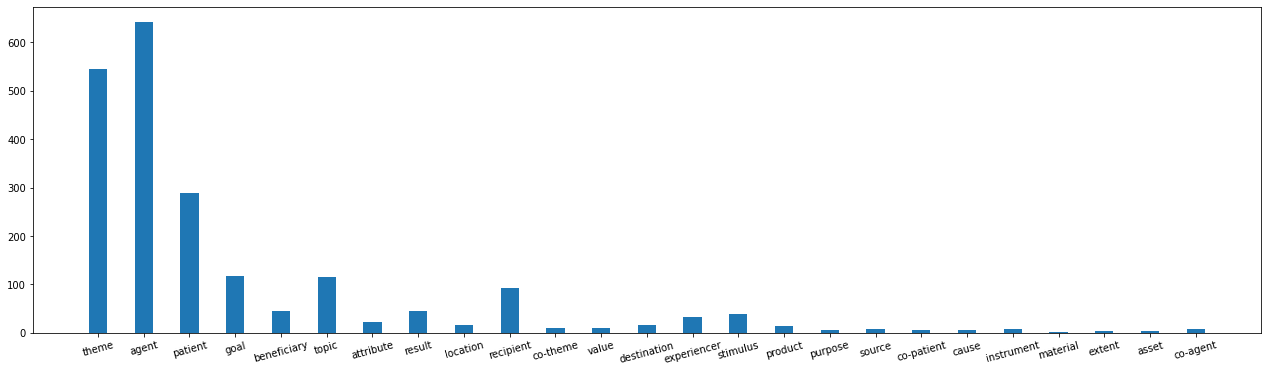

FR roles labels 26


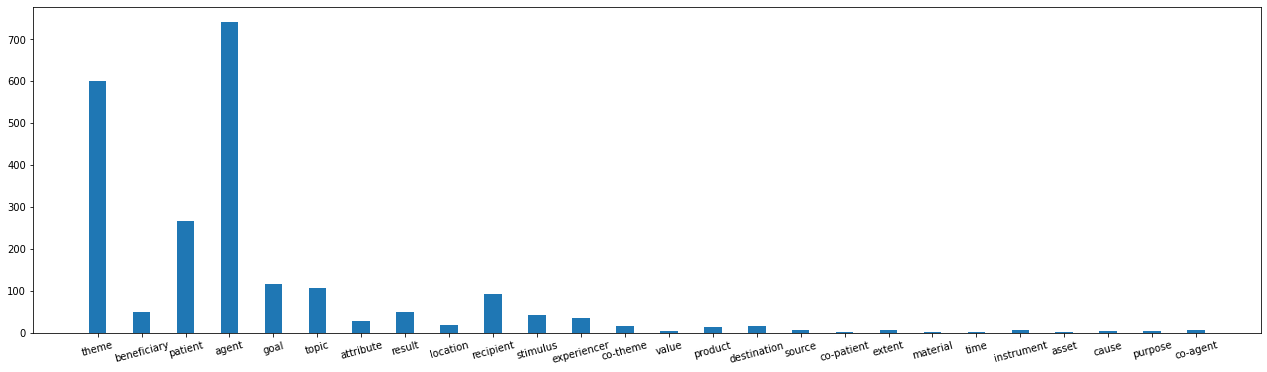

In [21]:
roles_c_en_train = dataset_train_en.get_roles_distribution(dataset_train_en.data_raw)
print('EN roles labels',len(list(roles_c_en_train)))
print_counter_distribution(roles_c_en_train)

roles_c_es_train = dataset_train_es.get_roles_distribution(dataset_train_es.data_raw)
print('ES roles labels',len(list(roles_c_es_train)))
print_counter_distribution(roles_c_es_train)

roles_c_fr_train = dataset_train_fr.get_roles_distribution(dataset_train_fr.data_raw)
print('FR roles labels',len(list(roles_c_fr_train)))
print_counter_distribution(roles_c_fr_train)

In [24]:
next(iter(dataset_train_en)).keys()

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words', 'predicate_position', 'predicate_label', 'predicate_word'])

In [25]:
global_params.update({ 
    'n_roles_labels': len(dataset_train_en.labels['id_to_roles']),
    'n_predicates_labels': len(dataset_train_en.labels['id_to_predicates']),
    'embedding_word_shape': (embedding_layer.num_embeddings, embedding_layer.embedding_dim),
    'embedding_word_padding_idx': vocabulary['pad_id'],
    'embedding_word_requires_grad': not embedding_word_freeze,
})

Saving global variables...

In [26]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# DataLoader

In [27]:
from torch.utils.data import DataLoader

In [28]:
dataloader_train_en = DataLoader(
    dataset_train_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=4,
    shuffle=True,
)

In [29]:
dataloader_dev_en = DataLoader(
    dataset_dev_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en.create_collate_fn(),
    num_workers=4,
    shuffle=False,
)

In [30]:
for e in dataloader_dev_en:
    ex_in = e
    break

In [31]:
ex_in.keys()

dict_keys(['words', 'lemmas', 'pos_tags', 'dependency_heads', 'dependency_relations', 'predicates', 'predicate_position', 'roles'])

In [32]:
print(ex_in['words'][0], len(ex_in['words'][0]))

[400001, 400001, 11565, 12, 0, 400001, 165, 642, 56, 999, 4, 122640, 0, 235, 3, 0, 264, 2500, 1848, 1, 194, 5, 1102, 340, 59, 473, 417, 2, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000] 126


In [33]:
print(ex_in['predicates'][0])

[0, 0, 297, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [34]:
print(ex_in['roles'][0])

[0, 1, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


# Printing model

In [36]:
from stud.modelsTests.utils.print_infos import *

# Wrapping everything

In [37]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [38]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_lstm import ArgIdenClassModel

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
)

import torch.optim as optim

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(final_model.model.parameters(), lr=0.0016)

In [39]:
print_summary(final_model.model)

Net_aic_lstm(
  (word_embedding): Embedding(400002, 300, padding_idx=400000)
  (word_lstm): LSTM(715, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=256, out_features=28, bias=True)
  (loss_fn): CrossEntropyLoss()
  (relu): ReLU()
)
----------------------
parameters: 125,286,260
trainable parameters: 5,285,660
non-trainable parameters: 120,000,600


# Training

In [40]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [41]:
from stud.modelsTests.utils.Trainer_aic_lstm import Trainer_aic_lstm

final_model.model.eval()
final_model.model.to(device)

trainer = Trainer_aic_lstm()

with torch.no_grad():
    ex_out = trainer.compute_forward(
        final_model.model, ex_in, device, optimizer = None)

    ex_l, ex_p, ex_loss = ex_out['labels'], ex_out['predictions'], ex_out['loss'],

ex_p_f = final_model.model.get_indices(ex_p)

print(
    'labels:','\n',
    ex_l.detach().cpu().tolist()[0],'\n',
    'predictions:','\n',
    ex_p_f.detach().cpu().tolist()[0])

labels: 
 [0, 1, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] 
 predictions: 
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 8, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16]


In [42]:
history = {}

In [43]:
from stud.modelsTests.utils.Trainer_aic_lstm import Trainer_aic_lstm

trainer = Trainer_aic_lstm()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs = 300, device = device,
    save_best = True, 
    min_score = 0.5,
    save_path_name = os.path.join(model_dir_path, 'aic_lstm_weights.pth'),
    saved_history = history,
)

Epoch   0 => avg_loss: 0.362706
# Validation loss => 0.304240 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   1 => avg_loss: 0.314244
# Validation loss => 0.294974 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   2 => avg_loss: 0.304378
# Validation loss => 0.284179 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   3 => avg_loss: 0.296156
# Validation loss => 0.277855 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   4 => avg_loss: 0.291203
# Validation loss => 0.273032 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   5 => avg_loss: 0.286601
# Validation loss => 0.268762 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   6 => avg_loss: 0.282131
# Validation loss => 0.264040 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   7 => avg_loss: 0.277748
# Validation loss => 0.259402 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   8 => avg_loss: 0.272998
# Validation loss => 0.253986 | 

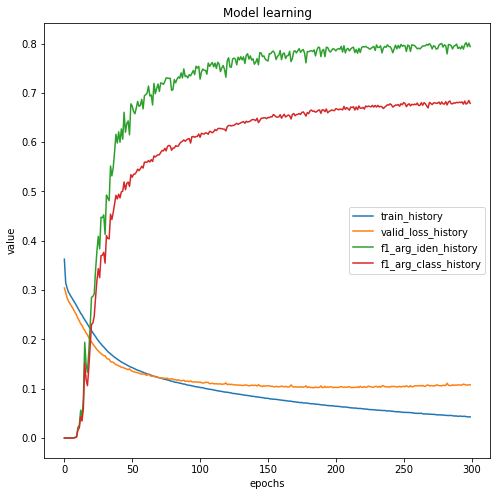

In [44]:
display_history(history)